In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.09982061776030171
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('chicago_bean_1', thickness, width, weaving_dir)

0.033273539253433904 0.0023291477477403733


In [5]:
import py_newton_optimizer
# Optimization parameters.
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-8
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 0.01
sw = 10
drw = 0.01
dsw = 0.1

In [6]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=False)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [8]:
curved_linkage.setExtendedDoFsPSRL(np.load('../results/chicago_bean_1/chicago_bean_1_dof.npy'))

In [6]:
# set_surface_view_options(curved_linkage_view, surface_transparent = True)

In [7]:
# double_view = get_double_side_view(curved_linkage, flip = True)

In [8]:
# double_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [9]:
# double_view.getCameraParams()

In [10]:
curved_linkage.attraction_weight = 1e-5

In [11]:
# iterateData = stage_1_optimization(curved_linkage, 0.01, 0.01, curved_linkage_view)

In [12]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [13]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.00096042	0.588633	0.588633	1	1
1	5.72765e-05	0.0288321	0.0288321	1	1
2	3.64006e-05	0.00677128	0.00677128	1	1
3	2.94144e-05	0.00290776	0.00290776	1	1
4	2.48347e-05	0.00138301	0.00138301	1	1
5	2.17479e-05	0.000709811	0.000709811	1	1
6	1.98367e-05	0.000373551	0.000373551	1	1
7	1.88065e-05	0.000221651	0.000221651	1	1
8	1.83241e-05	0.000185954	0.000185954	1	1
9	1.81237e-05	0.000156921	0.000156921	1	1
10	1.8048e-05	0.000106891	0.000106891	1	1
11	1.80212e-05	5.98969e-05	5.98969e-05	1	1
12	1.80119e-05	3.11861e-05	3.11861e-05	1	1
13	1.80086e-05	1.56662e-05	1.56662e-05	1	1
14	1.80074e-05	7.61421e-06	7.61421e-06	1	1
15	1.8007e-05	3.58077e-06	3.58077e-06	1	0
16	1.80069e-05	1.2615e-05	1.2615e-05	1	0
17	1.80069e-05	9.06039e-11	9.06039e-11	1	0


In [14]:
# optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [14]:
# optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -5, 3)

In [16]:
# curved_optimizer_energy = curved_linkage.energy()
# validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
# validation_curved_linkage.attraction_weight = 1e-7
# with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = [])
# validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
# validation_curved_energy = validation_curved_linkage.energy()
# print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

In [17]:
# validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
# set_surface_view_options(validation_curved_view)
# validation_curved_view.show()

In [18]:
# deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(validation_curved_linkage)

In [19]:
# set_joint_vector_field(validation_curved_linkage, validation_curved_view, deviation_vector)

In [20]:
# os.chdir(save_path)

In [21]:
# save_path = os.getcwd()
# write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
# os.chdir(save_path)

Coefficient of Friction Percentiles 50, 75, 90:  0.5316860143446809 1.185361355250992 3.1656820931216774


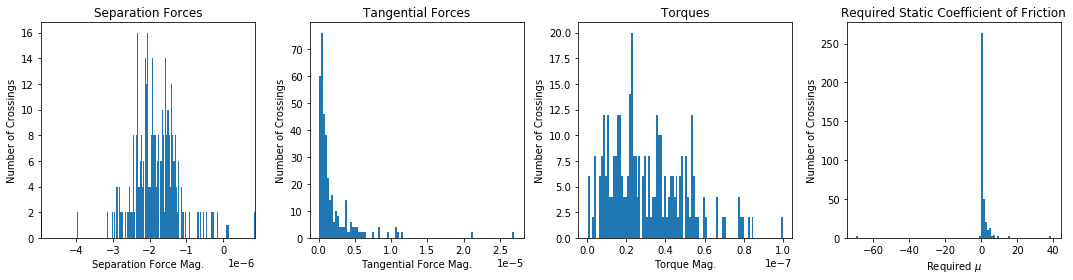

In [15]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [16]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, inner_gradTol = 1e-6)

In [26]:
idata = {t.name: t.term.value() for t in optimizer.objective.terms}


In [27]:
idata

{'ElasticEnergy': 1.0,
 'TargetFitting': 0.019057478637852017,
 'RestLengthMinimization': 0.01,
 'RestCurvatureSmoothing': 0.002384306534639184,
 'ContactForce': 7.855419931191972e-06}

In [ ]:
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 5e8, normalWeight = 10, torqueWeight = 0, maxIter=2000, normalActivationThreshold=-1e-7)

In [ ]:
second_structure_view = get_structure_analysis_view(curved_linkage)
second_structure_view.show()